In [5]:
from matplotlib import pyplot as plt
import json
import torch
import csv
import os
import re
from pycocotools.coco import COCO
from PIL import Image
import random

plt.rcParams['font.family'] = 'Arial'

In [2]:
datadir = "/home/messina/data_messina/DatiMaltese"

dset = {
    '_target_': 'src.data.datasets.CocoCaptions',
    'root': f"{datadir}/coco_dataset/coco_val_swap_new/",
    'annFile': f"{datadir}/coco_dataset/annotations/captions_val2017.json",
    'features_json': f"{datadir}/Visual_Name_Entity_Recognition/gender_faceswap_new_val_test_set/features_new_entities_test_small_faceswap.json",
    'entities_to_names_file': f"{datadir}/vggface_test_kaggle/identity_meta.csv",
    'vggface_dir': f"{datadir}/vggface_test_kaggle",
}

coco = COCO(dset['annFile'])
ids_tot = list(sorted(coco.imgs.keys()))

with open(dset['features_json'], "r") as file_train:
    f = json.load(file_train)
features = {key: torch.FloatTensor(value) for key, value in f.items()}
ids = list(features.keys())

with open(dset['entities_to_names_file'], "r") as file:
    reader = csv.DictReader(file, skipinitialspace=True)
    entity_to_name = {row["Class_ID"]: row["Name"].replace('_', ' ') for row in reader}

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [3]:
key_words = [
        "person",
        "man",
        "mother",
        "father",
        "dad",
        "mum",
        "woman",
        "child",
        "boy",
        "guy",
        "girl",
        "kid",
        "human",
        "adult",
        "male",
        "female",
        "lady",
        "teenager",
        "baby"
    ]

templates = [
    # "An image with [ENTITY]. [CAPTION]",
    # "An image with a person whose name is [ENTITY]. [CAPTION]",
    # "[ENTITY]. [CAPTION]",
    # "A picture of [ENTITY]. [CAPTION]",
    # "[ENTITY] in the image. [CAPTION]",
    # "There is [ENTITY] in the picture. [CAPTION]",
    "[C_CHUNK_1] [ENTITY] [C_CHUNK_2]",
    "[C_CHUNK_1] [KEYWORD] ([ENTITY]) [C_CHUNK_2]",
    "[C_CHUNK_1] [KEYWORD] (whose name is [ENTITY]) [C_CHUNK_2]",
    "[C_CHUNK_1] famous [KEYWORD] [ENTITY] [C_CHUNK_2]",
    "[C_CHUNK_1] famous [ENTITY] [C_CHUNK_2]"
]

def load_image(id: int, entity = None):
    path = coco.loadImgs(id)[0]["file_name"] # ritorna l'array di un singolo elemento, lo recupera e prende solo il nome dell'immagine
    #print(path)
    if entity is None:
        return Image.open(os.path.join(dset['root'], path)).convert("RGB") # caso in cui i nomi dei file non siano diversi da dagli id
    else:
        path_image_swap = path+'_'+entity+'.jpg'
        return Image.open(os.path.join(dset['root'], path_image_swap)).convert("RGB")
    
def load_target(id: int):
    return coco.loadAnns(coco.getAnnIds(id))

def caption_configuration(caption, entity_expansion_template=None, entity_name=None):
    default_templates = [
        "An image with [ENTITY]. [CAPTION]",
        "An image with a person whose name is [ENTITY]. [CAPTION]",
        "[ENTITY]. [CAPTION]",
        "A picture of [ENTITY]. [CAPTION]",
        "[ENTITY] in the image. [CAPTION]",
        "There is [ENTITY] in the picture. [CAPTION]"
    ]

    assert not (any(['CAPTION' in t or 'C_CHUNK' in t for t in templates]) and caption is None)
    word_ref = None
    count = 0

    if key_words and caption is not None:
        target_to_analize = caption.lower()
        for word in key_words:
            pattern = fr'\b{word}\b'
            if re.search(pattern, target_to_analize):
                count += 1
                word_ref = word

    if word_ref is not None:
        if word_ref.capitalize() in caption:
            word_ref = word_ref.capitalize()
        elif word_ref.upper() in caption:
            word_ref = word_ref.upper()
        caption_split = caption.split(word_ref)

    templates_w_keyword = [t for t in templates if 'C_CHUNK_1' in t]
    templates_wo_keyword = [t for t in templates if 'C_CHUNK_1' not in t]
    new_captions = [c.replace('[CAPTION]', caption) if caption is not None else c for c in templates_wo_keyword]

    if word_ref is not None and count == 1 and len(caption_split) == 2:
        captions = [
            t
            .replace('a [ENTITY]', '[ENTITY]')
            .replace('A [ENTITY]', '[ENTITY]')
            .replace('an [ENTITY]', '[ENTITY]')
            .replace('An [ENTITY]', '[ENTITY]')
            .replace('[C_CHUNK_1]', caption_split[0].strip())
            .replace('[C_CHUNK_2]', caption_split[1].strip())
            .replace('[KEYWORD]', word_ref)
            for t in templates_w_keyword
        ]

        captions = [re.sub(fr',(?![\s\d])', ', ', t) if re.search(fr',(?!\s)', t) else t for t in captions]
        new_captions.extend(captions)
            
    elif (count != 1 or len(caption_split) != 2) and key_words is not None:
        # repeat some captions for the last 3 elements to have alsways the same number of elements in the list
        # otherwise it is difficult to batch them
        if len(new_captions) > 0:
            new_captions.extend(random.choices(new_captions, k=len(templates_w_keyword)))
        else:
            new_captions = random.choices(default_templates, k=len(templates_w_keyword))

    # substitute [ENTITY] with the entity_expansion
    split_captions = [c.split('[ENTITY]') if '[ENTITY]' in c else None for c in new_captions]
    new_captions = [
        entity_expansion_template
        .replace('[T_CHUNK_1]', sc[0])
        .replace('[T_CHUNK_2]', sc[1]) 
        .replace('[NAME]', entity_name)
        if sc is not None else c
        for sc, c in zip(split_captions, new_captions)
    ]

    # assert not any([('[' in c) and (']' in c) for c in new_captions]), f"Error in caption configuration: {new_captions}"

    return new_captions

def retrieve_data_from_id(id):
    list_id_entity = id.split('_')
    id_swap = int(list_id_entity[0])
    entity = list_id_entity[1]
    entity_name = entity_to_name[entity]
    entity_image = Image.open(os.path.join(dset['vggface_dir'], entity, '0001_01.jpg')).convert("RGB")
    image = load_image(id_swap, entity)
    target_partial = load_target(id_swap)
    target_partial = [t['caption'] for t in target_partial]
    # chosen_caption = target_partial[random.randint(0, len(target_partial) - 1)]
    chosen_caption = [t for t in target_partial if any([k in t.lower() for k in key_words])]
    chosen_caption = chosen_caption[random.randint(0, len(chosen_caption) - 1)]
    # if len(chosen_caption) != 0 and random.choice([True, False]):
    #     chosen_caption = chosen_caption[random.randint(0, len(chosen_caption) - 1)]
    # else:
    #     chosen_caption = target_partial[random.randint(0, len(target_partial) - 1)]
    new_captions = caption_configuration(str(chosen_caption), entity_name=entity_name, entity_expansion_template="[T_CHUNK_1][NAME][T_CHUNK_2]")

    new_captions = [
        '. '.join([sentence[0].upper() + sentence[1:] if sentence else sentence for sentence in caption.split('. ')])
        for caption in new_captions
    ]

    return {
        "image": image,
        "texts": new_captions,
        "person_name": entity_name,
        "person_image": entity_image
    }

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

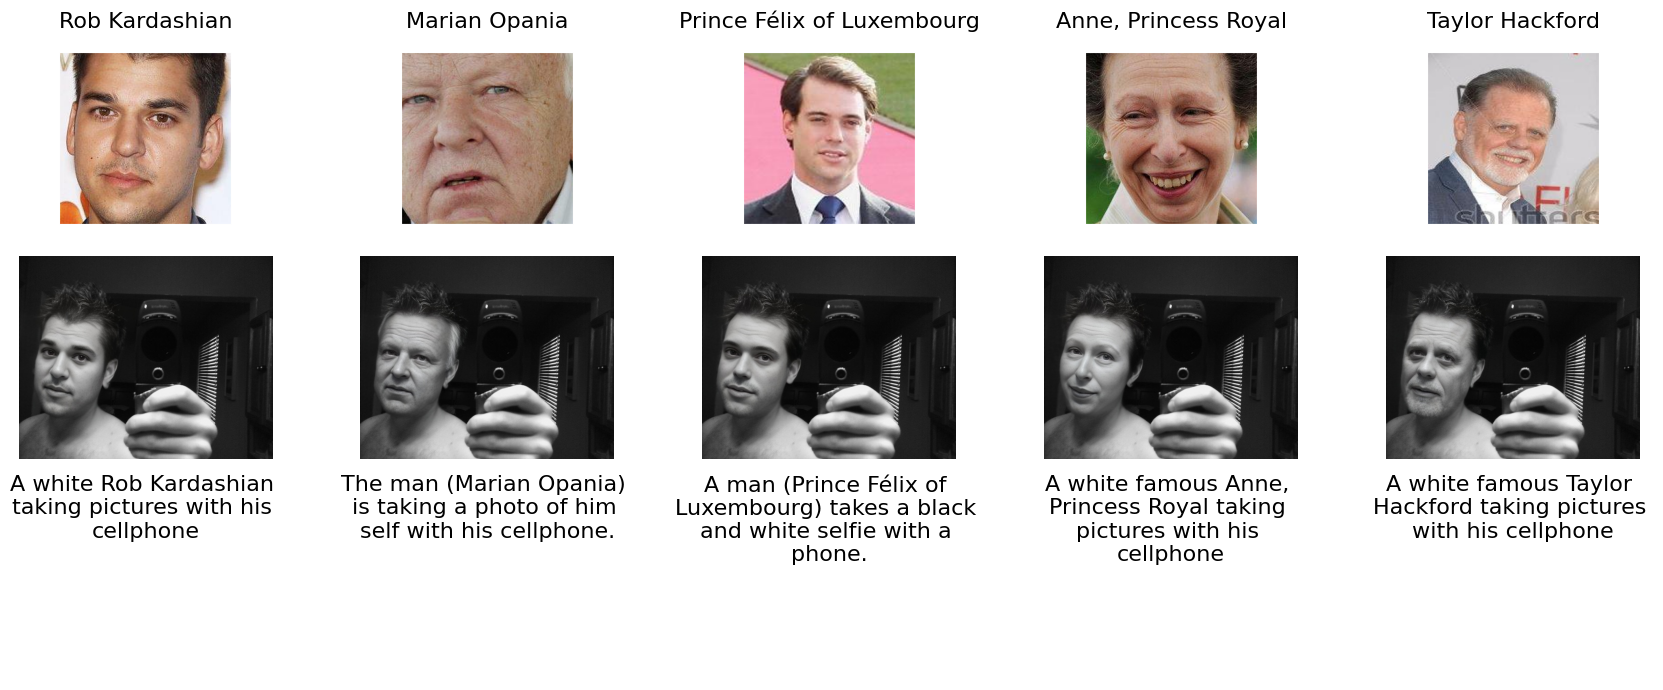

In [6]:
def draw_image(show_ids, num_captions=1):
    fig, axes = plt.subplots(3, len(show_ids), figsize=(17, 7))

    for i, id in enumerate(show_ids):
        data = retrieve_data_from_id(id)
        texts = random.sample(data["texts"], num_captions)
        
        # Display the main image
        axes[1, i].imshow(data["image"])
        axes[1, i].axis('off')
        
        # Center crop the person image
        width, height = data["person_image"].size
        new_width, new_height = 250, 250
        if width < new_width or height < new_height:
            person_image_cropped = data["person_image"].resize((new_width, new_height))
        else:
            left = (width - new_width) / 2
            top = (height - new_height) / 2
            right = (width + new_width) / 2
            bottom = (height + new_height) / 2
            person_image_cropped = data["person_image"].crop((left, top, right, bottom))

        # Pad the person image to 400x400 with white color
        new_size = (300, 300)
        person_image_padded = Image.new("RGB", new_size, (255, 255, 255))
        person_image_padded.paste(person_image_cropped, ((new_size[0] - new_width) // 2, (new_size[1] - new_height) // 2))
        
        # Display the person image
        axes[0, i].imshow(person_image_padded)
        axes[0, i].axis('off')
        axes[0, i].set_title(data["person_name"], fontsize=16)
        
        # Display the texts
        captions = "\n\n".join(
            "\n".join(re.findall('.{1,25}(?:\s+|$)', line)) 
            for line in texts
        )
        axes[2, i].text(0.5, 1.0, captions, ha='center', va='top', wrap=True, fontsize=16)
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

random.seed(42)
context = "302882"
show_ids = [id for id in ids if id.startswith(context)]
draw_image(show_ids)